In [1]:
import xgboost as xgb
import awkward as ak
import matplotlib.pyplot as plt
import hist
import warnings
import pickle
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import numpy as np

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

In [61]:
gluons = ak.from_parquet('/project01/ndcms/cmoore24/skims/gluon_finding/truth_samples/gluons/test/*')
quarks = ak.from_parquet('/project01/ndcms/cmoore24/skims/gluon_finding/truth_samples/quarks/test/*')

In [62]:
train = 'kinematics'

In [63]:
trees = '1000'

In [64]:
feature_names = [
    'area',
    'eta',
    'mass',
    'msoftdrop',
    'n2b1',
    'n3b1',
    'phi',
    'pt',
    # 'rawFactor',
    'tau1',
    'tau2',
    'tau3',
    'tau4',
]

In [65]:
len(feature_names)

12

In [66]:
path = f'/scratch365/cmoore24/training/hgg/quark_gluon/output/{train}/{trees}'

In [67]:
bst = xgb.Booster()
bst.load_model(f'{path}/bdt_model.json')

In [68]:
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [69]:
gluons_np = np.column_stack([ak.to_numpy(gluons[feature]) for feature in feature_names])
quarks_np = np.column_stack([ak.to_numpy(quarks[feature]) for feature in feature_names])

In [70]:
gluons_np = scaler.transform(gluons_np)
quarks_np = scaler.transform(quarks_np)

In [71]:
gluons_xgb = xgb.DMatrix(gluons_np, feature_names=feature_names)
quarks_xgb = xgb.DMatrix(quarks_np, feature_names=feature_names)

In [72]:
gluons['gluon_scores'] = bst.predict(gluons_xgb)

In [73]:
quarks['quark_scores'] = bst.predict(quarks_xgb)

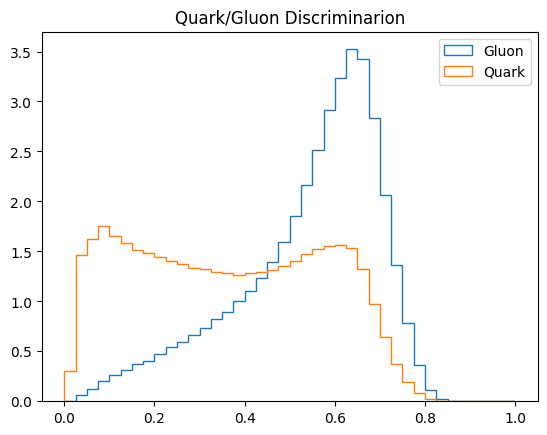

In [74]:
plt.hist(gluons.gluon_scores, bins=40, histtype='step', label='Gluon', density=True, range=(0,1))
plt.hist(quarks.quark_scores, bins=40, histtype='step', label='Quark', density=True, range=(0,1))
plt.title(f'Quark/Gluon Discriminarion')
plt.legend()
plt.savefig(f'score_dists/{train}_{trees}.png', bbox_inches='tight')
plt.show()

In [75]:
mask = ~np.isnan(quarks.quark_scores)
quark_scores = quarks.quark_scores[mask]# & (qcd_scores > -6) & (qcd_scores < 6)]
quark_train = quarks[mask]

In [76]:
mask = ~np.isnan(gluons.gluon_scores)
gluon_scores = gluons.gluon_scores[mask]# & (hgg_scores > -6) & (hgg_scores < 6)]
gluon_train = gluons[mask]

In [77]:
bkg_zeros = ak.zeros_like(quarks.quark_scores)
sig_ones = ak.ones_like(gluons.gluon_scores)
combined = ak.concatenate([quarks.quark_scores,gluons.gluon_scores])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [78]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [79]:
hrange=(np.floor(ak.min(gluons.gluon_scores)), np.ceil(ak.max(gluons.gluon_scores)))

In [80]:
gluon_hist = np.histogram(gluon_scores, bins=10,
                range=hrange
                )
quark_hist = np.histogram(quark_scores, bins=10, 
                 range=hrange
                )

In [81]:
sig_sums = []
for i in range(len(gluon_hist[0])+1):
    sig_sums.append(sum(gluon_hist[0][len(gluon_hist[0])-i:]))

bkg_sums = []
for i in range(len(quark_hist[0])+1):
    bkg_sums.append(sum(quark_hist[0][len(quark_hist[0])-i:]))

In [82]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [83]:
wp_ratios = {}
for i in range(len(gluon_hist[1])):
    wp_ratios[str(gluon_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

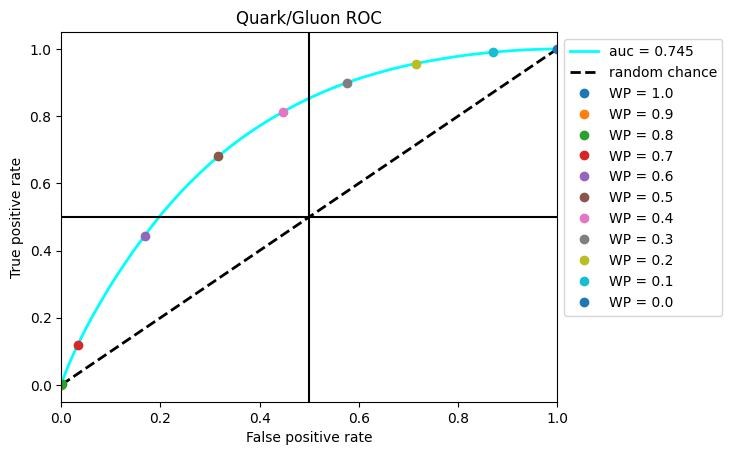

In [84]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Quark/Gluon ROC")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
for i in wp_ratios:
    plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {float(i):.1f}')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f'rocs/{train}_{trees}.png', bbox_inches='tight')
plt.show()

In [85]:
feature_strength = bst.get_score(importance_type="gain")
feature_strength_full = {f: feature_strength.get(f, 0.0) for f in feature_names}

In [86]:
sorted_by_values = dict(sorted(feature_strength_full.items(), key=lambda item: item[1], reverse=True))

In [87]:
# with open('strength_jsons/data_vs_mc_strengths_75.json', 'w') as f:
#     json.dump(feature_strength_full, f)

In [88]:
sorted_by_values

{'tau4': 1230.339111328125,
 'n2b1': 556.2870483398438,
 'eta': 325.57562255859375,
 'n3b1': 163.4793701171875,
 'tau1': 81.75553131103516,
 'msoftdrop': 57.329952239990234,
 'tau2': 53.86075973510742,
 'area': 51.70381164550781,
 'mass': 43.58195495605469,
 'pt': 42.97266387939453,
 'tau3': 15.511345863342285,
 'phi': 9.979701042175293}